Columns after renaming: Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'Latitude', 'Longitude'],
      dtype='object')


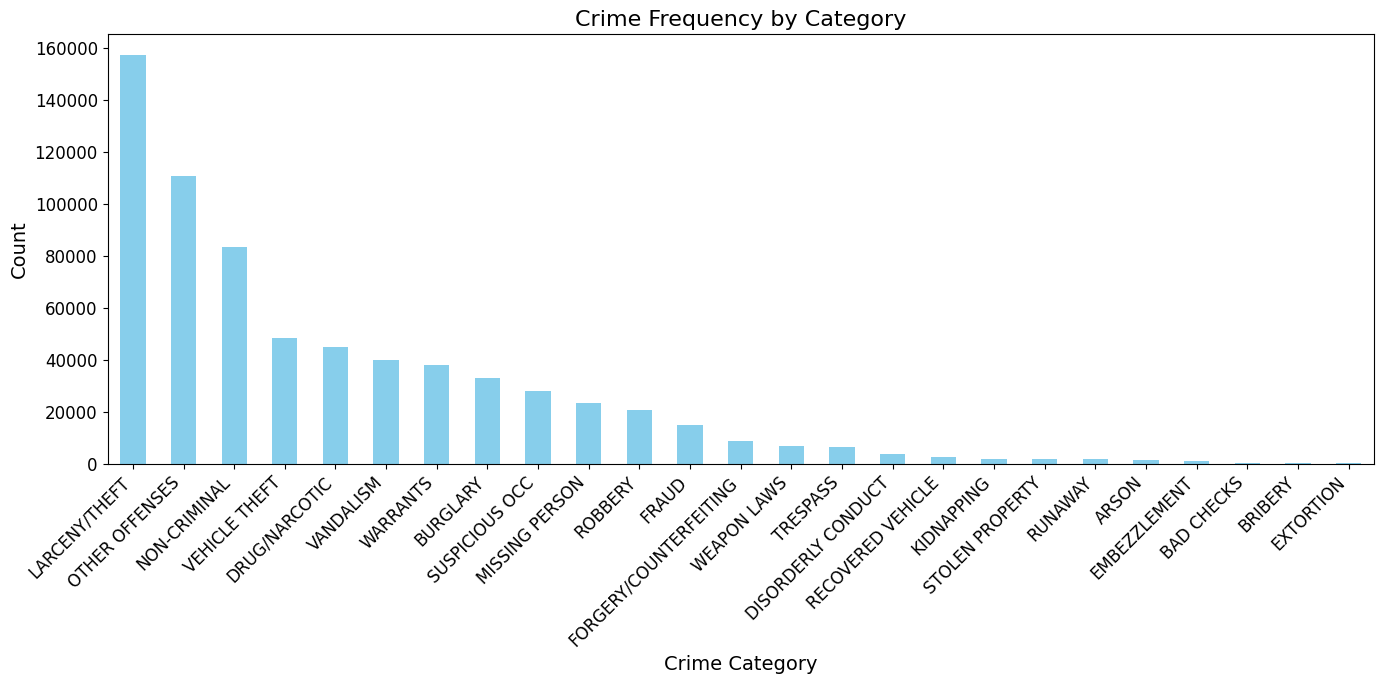

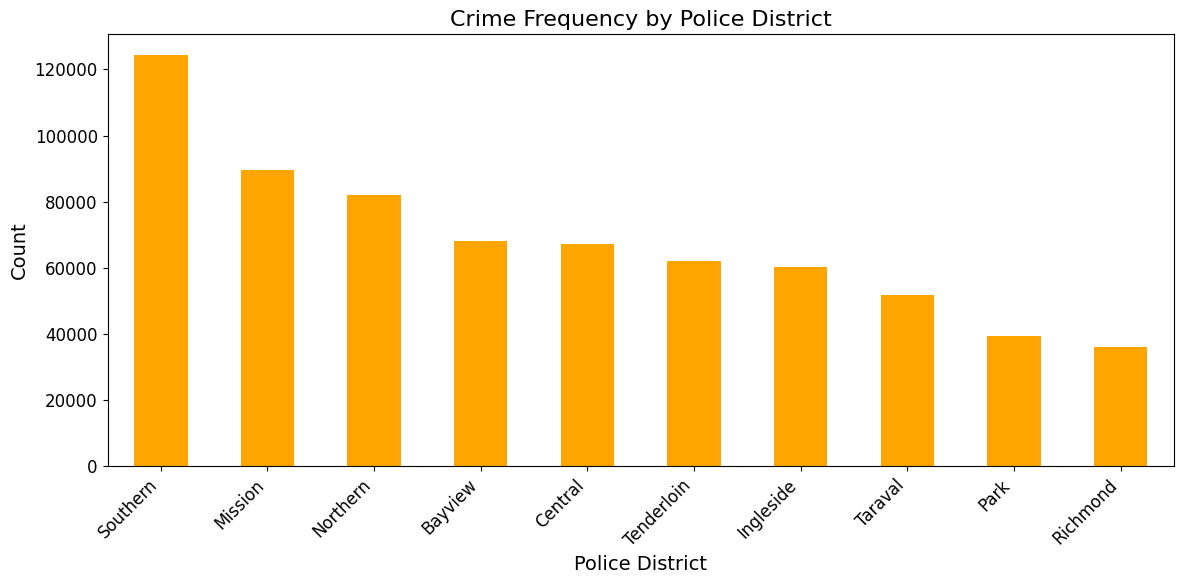

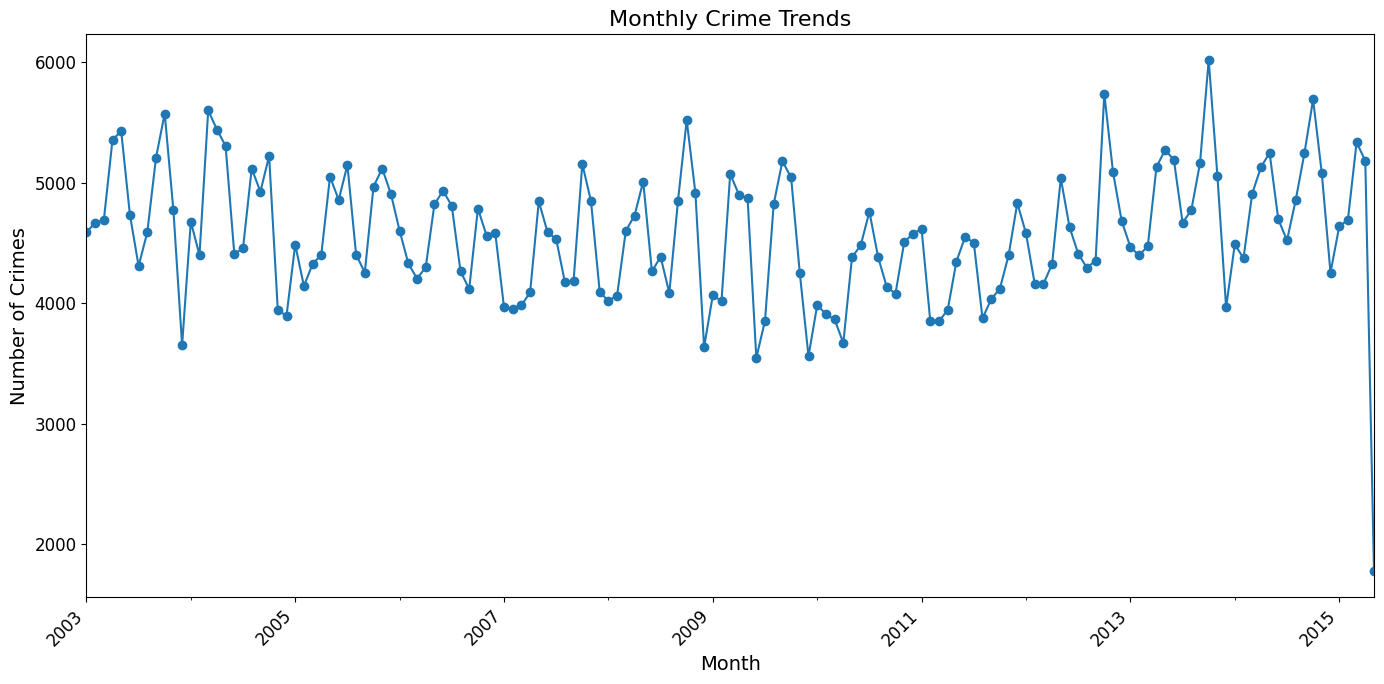

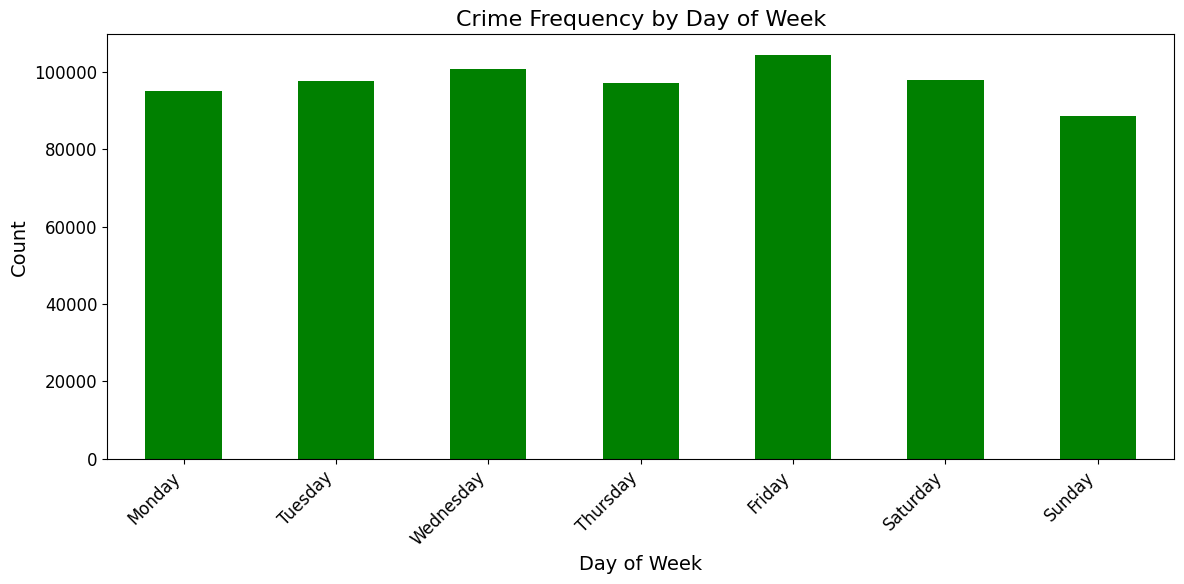

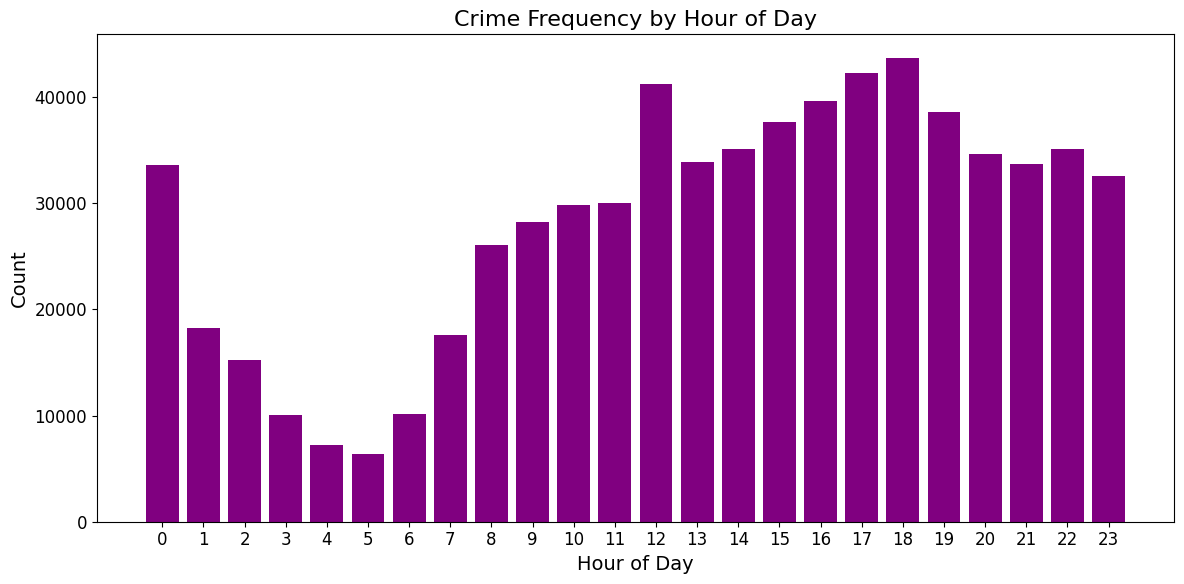

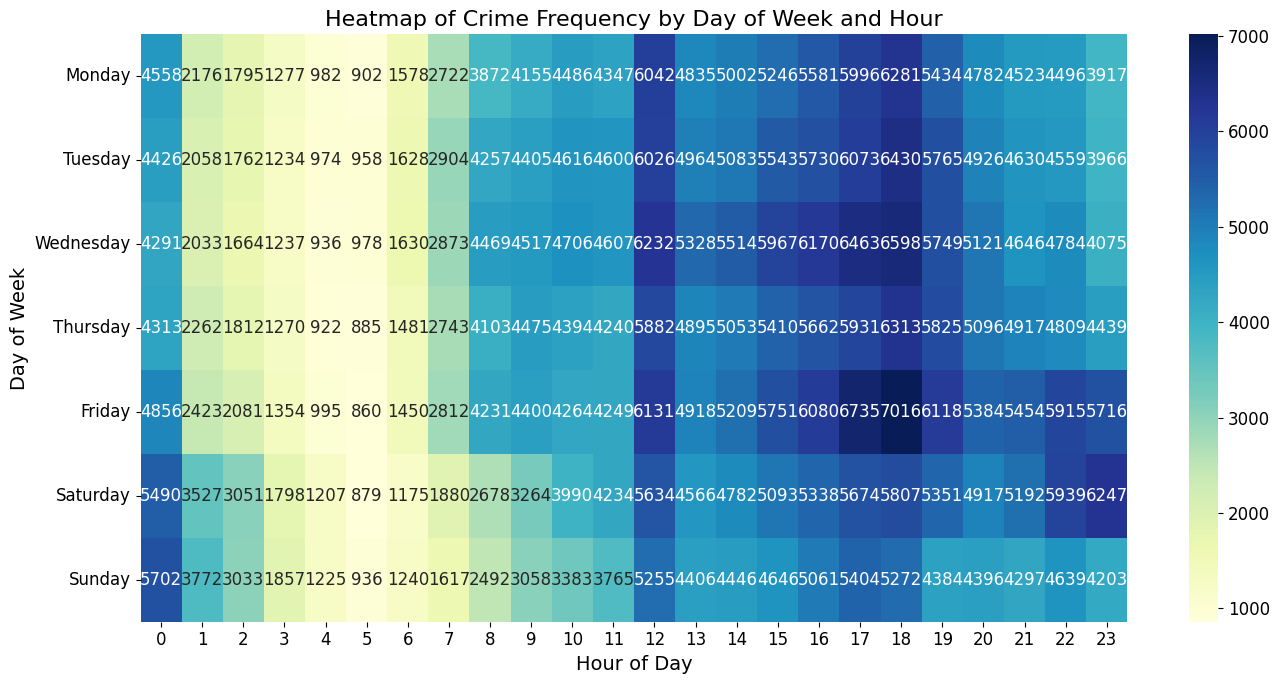

Dataset has 680826 records, sampling 1000 for the map display.



Data Analysis Summary:
- Total records: 680826
- Unique crime categories: 25
- Most common crime category: LARCENY/THEFT with 157238 occurrences.
- Unique police districts: 10
- Most active police district: Southern with 124373 occurrences.
- Date range: 2003-01-06 to 2015-05-13
- Most common day for crimes: Friday with 104402 occurrences.
- Peak crime hour: 18:00 with 43717 occurrences.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from datetime import datetime
import os
import webbrowser

try:
    from IPython.display import display
    inline_display = True
except ImportError:
    inline_display = False

plt.rcParams.update({'font.size': 12})

# --- Data Loading & Cleaning ---
df = pd.read_csv('Competition_Dataset.csv', parse_dates=['Dates'])

# Rename columns from 'Latitude (Y)' and 'Longitude (X)' to 'Latitude' and 'Longitude'
df.rename(columns={'Latitude (Y)': 'Latitude', 'Longitude (X)': 'Longitude'}, inplace=True)

# Standardize text columns.
df['Category'] = df['Category'].str.upper().str.strip()
df['Descript'] = df['Descript'].str.lower().str.strip()
df['DayOfWeek'] = df['DayOfWeek'].str.title().str.strip()
df['PdDistrict'] = df['PdDistrict'].str.title().str.strip()

# --- Exploratory Visualizations ---

# 1. Crime Frequency by Category
category_counts = df['Category'].value_counts()
plt.figure(figsize=(14,7))
ax1 = plt.gca()
category_counts.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Crime Frequency by Category', fontsize=16)
ax1.set_xlabel('Crime Category', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# 2. Crime Frequency by Police District
district_counts = df['PdDistrict'].value_counts()
plt.figure(figsize=(12,6))
ax2 = plt.gca()
district_counts.plot(kind='bar', ax=ax2, color='orange')
ax2.set_title('Crime Frequency by Police District', fontsize=16)
ax2.set_xlabel('Police District', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Monthly Crime Trends
df['Month'] = df['Dates'].dt.to_period('M')
monthly_counts = df.groupby('Month').size()
plt.figure(figsize=(14,7))
ax3 = plt.gca()
monthly_counts.plot(kind='line', marker='o', ax=ax3)
ax3.set_title('Monthly Crime Trends', fontsize=16)
ax3.set_xlabel('Month', fontsize=14)
ax3.set_ylabel('Number of Crimes', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Crime Frequency by Day of Week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['DayOfWeek'].value_counts().reindex(days_order)
plt.figure(figsize=(12,6))
ax4 = plt.gca()
day_counts.plot(kind='bar', ax=ax4, color='green')
ax4.set_title('Crime Frequency by Day of Week', fontsize=16)
ax4.set_xlabel('Day of Week', fontsize=14)
ax4.set_ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# 5. Crime Frequency by Hour
df['Hour'] = df['Dates'].dt.hour
hour_counts = df['Hour'].value_counts().sort_index()
plt.figure(figsize=(12,6))
ax5 = plt.gca()
ax5.bar(hour_counts.index, hour_counts.values, color='purple')
ax5.set_title('Crime Frequency by Hour of Day', fontsize=16)
ax5.set_xlabel('Hour of Day', fontsize=14)
ax5.set_ylabel('Count', fontsize=14)
plt.xticks(range(0, 24), fontsize=12)
plt.tight_layout()
plt.show()

# 6. Heatmap: Crime Frequency by Day of Week and Hour
pivot_data = df.pivot_table(index='DayOfWeek', columns='Hour', values='Category', aggfunc='count')
pivot_data = pivot_data.reindex(days_order)  # Ensure correct day order.
plt.figure(figsize=(14,7))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Crime Frequency by Day of Week and Hour', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Day of Week', fontsize=14)
plt.tight_layout()
plt.show()

# 7. Geographic Distribution: Interactive Map using Folium

# Optimize: Sample markers if the dataset is large.
max_markers = 1000
if len(df) > max_markers:
    print(f"Dataset has {len(df)} records, sampling {max_markers} for the map display.")
    df_map = df.sample(max_markers)
else:
    df_map = df

# Create a base map centered on the average coordinates.
map_center = [df['Longitude'].mean(), df['Latitude'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=12)

# Add a marker cluster to group nearby markers.
marker_cluster = MarkerCluster().add_to(crime_map)

# Add markers for each crime incident in the sampled data.
for idx, row in df_map.iterrows():
    popup_text = (
        f"<strong>Category:</strong> {row['Category']}<br>"
        f"<strong>Description:</strong> {row['Descript']}<br>"
        f"<strong>District:</strong> {row['PdDistrict']}"
    )
    folium.Marker(
        location=[row['Longitude'], row['Latitude']],
        popup=popup_text
    ).add_to(marker_cluster)

if inline_display:
    display(crime_map)
else:
    map_file = "crime_map_folium.html"
    crime_map.save(map_file)
    abs_path = os.path.abspath(map_file)
    map_link = f"file://{abs_path}"
    print("Folium map saved to:", map_file)
    print("Open the link below in your browser to view the map:")
    print(map_link)
    webbrowser.open(map_link)

# --- Analysis Summary ---
analysis_summary = f"""
Data Analysis Summary:
- Total records: {len(df)}
- Unique crime categories: {df['Category'].nunique()}
- Most common crime category: {df['Category'].mode()[0]} with {category_counts.max()} occurrences.
- Unique police districts: {df['PdDistrict'].nunique()}
- Most active police district: {df['PdDistrict'].mode()[0]} with {district_counts.max()} occurrences.
- Date range: {df['Dates'].min().date()} to {df['Dates'].max().date()}
- Most common day for crimes: {day_counts.idxmax()} with {day_counts.max()} occurrences.
- Peak crime hour: {hour_counts.idxmax()}:00 with {hour_counts.max()} occurrences.
"""
print(analysis_summary)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# --- Data Loading & Cleaning ---
df = pd.read_csv('Competition_Dataset.csv', parse_dates=['Dates'])
print("Missing values BEFORE cleaning:")
print(df[['Descript', 'Category']].isnull().sum())
df.rename(columns={'Latitude (Y)': 'Latitude', 'Longitude (X)': 'Longitude'}, inplace=True)

# Standardize text columns.
df['Category'] = df['Category'].str.upper().str.strip()
df['Descript'] = df['Descript'].str.lower().str.strip()
df['DayOfWeek'] = df['DayOfWeek'].str.title().str.strip()
df['PdDistrict'] = df['PdDistrict'].str.title().str.strip()

# Display missing value counts after cleaning.
print("\nMissing values AFTER cleaning (before dropping nulls):")
print(df[['Descript', 'Category']].isnull().sum())

# Drop rows with missing values in 'Descript' or 'Category'
df = df.dropna(subset=['Descript', 'Category'])
print("\nDataset shape after dropping null values:", df.shape)

# --- Prepare Data for Text Classification ---
X = df['Descript']   # Feature: crime description.
y = df['Category']   # Label: crime category.

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for text classification:
# TF-IDF vectorization followed by Logistic Regression.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model on the training data.
pipeline.fit(X_train, y_train)

# Make predictions on the test set.
y_pred = pipeline.predict(X_test)

# Evaluate the model.
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))

# --- Severity Mapping ---
severity_mapping = {
    'NON-CRIMINAL': 1,
    'SUSPICIOUS OCCURRENCE': 1,
    'SUSPICIOUS OCC': 1, 
    'MISSING PERSON': 1,
    'RUNAWAY': 1,
    'RECOVERED VEHICLE': 1,
    'WARRANTS': 2,
    'OTHER OFFENSES': 2,
    'VANDALISM': 2,
    'TRESPASS': 2,
    'DISORDERLY CONDUCT': 2,
    'BAD CHECKS': 2,
    'LARCENY/THEFT': 3,
    'VEHICLE THEFT': 3,
    'FORGERY/COUNTERFEITING': 3,
    'DRUG/NARCOTIC': 3,
    'STOLEN PROPERTY': 3,
    'FRAUD': 3,
    'BRIBERY': 3,
    'EMBEZZLEMENT': 3,
    'ROBBERY': 4,
    'WEAPON LAWS': 4,
    'BURGLARY': 4,
    'EXTORTION': 4,
    'KIDNAPPING': 5,
    'ARSON': 5
}

# --- Function for Inference ---
def predict_crime(description):
    """
    Predicts the crime category from the description and assigns a severity level.
    """
    predicted_category = pipeline.predict([description])[0]
    severity = severity_mapping.get(predicted_category, "Unknown")
    return predicted_category, severity

# --- Example Usage with Multiple Cases ---
sample_descriptions = [
    "suspicious person loitering near parked cars",
    "broken window found at the mall",
    "vehicle theft reported near the university",
    "arson at abandoned building",
    "a group of vandals defacing public property"
]

for desc in sample_descriptions:
    predicted_category, severity_level = predict_crime(desc)
    print("\nSample Crime Description:", desc)
    print("Predicted Category:", predicted_category)
    print("Assigned Severity:", severity_level)


Missing values BEFORE cleaning:
Descript    0
Category    0
dtype: int64

Missing values AFTER cleaning (before dropping nulls):
Descript    0
Category    0
dtype: int64

Dataset shape after dropping null values: (680826, 9)

Model Accuracy: 99.68%
Classification Report:
                         precision    recall  f1-score   support

                 ARSON       1.00      1.00      1.00       294
            BAD CHECKS       1.00      1.00      1.00        86
               BRIBERY       1.00      0.98      0.99        51
              BURGLARY       1.00      1.00      1.00      6678
    DISORDERLY CONDUCT       1.00      1.00      1.00       819
         DRUG/NARCOTIC       1.00      1.00      1.00      8998
          EMBEZZLEMENT       1.00      1.00      1.00       204
             EXTORTION       1.00      1.00      1.00        43
FORGERY/COUNTERFEITING       1.00      1.00      1.00      1729
                 FRAUD       1.00      1.00      1.00      2994
            KIDNAPPING

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# --- Data Loading & Cleaning ---
df = pd.read_csv('Competition_Dataset.csv', parse_dates=['Dates'])
print("Missing values BEFORE cleaning:")
print(df[['Descript', 'Category']].isnull().sum())
df.rename(columns={'Latitude (Y)': 'Latitude', 'Longitude (X)': 'Longitude'}, inplace=True)

# Standardize text columns.
df['Category'] = df['Category'].str.upper().str.strip()
df['Descript'] = df['Descript'].str.lower().str.strip()
df['DayOfWeek'] = df['DayOfWeek'].str.title().str.strip()
df['PdDistrict'] = df['PdDistrict'].str.title().str.strip()

# Display missing value counts after cleaning.
print("\nMissing values AFTER cleaning (before dropping nulls):")
print(df[['Descript', 'Category']].isnull().sum())

# Drop rows with missing values in 'Descript' or 'Category'
df = df.dropna(subset=['Descript', 'Category'])
print("\nDataset shape after dropping null values:", df.shape)

# --- Prepare Data for Text Classification ---
X = df['Descript']   # Use the crime description as features.
y = df['Category']   # Use the crime category as labels.

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for text classification:
# TF-IDF vectorization followed by Multinomial Naive Bayes.
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
])

# Fit the model on the training data.
pipeline_nb.fit(X_train, y_train)

# Make predictions on the test set.
y_pred_nb = pipeline_nb.predict(X_test)

# Evaluate the model.
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("\nMultinomialNB Model Accuracy: {:.2f}%".format(accuracy_nb * 100))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

# --- Severity Mapping ---
# Including an alias for "SUSPICIOUS OCC" to map to severity level 1.
severity_mapping = {
    'NON-CRIMINAL': 1,
    'SUSPICIOUS OCCURRENCE': 1,
    'SUSPICIOUS OCC': 1,  # alias for consistency
    'MISSING PERSON': 1,
    'RUNAWAY': 1,
    'RECOVERED VEHICLE': 1,
    'WARRANTS': 2,
    'OTHER OFFENSES': 2,
    'VANDALISM': 2,
    'TRESPASS': 2,
    'DISORDERLY CONDUCT': 2,
    'BAD CHECKS': 2,
    'LARCENY/THEFT': 3,
    'VEHICLE THEFT': 3,
    'FORGERY/COUNTERFEITING': 3,
    'DRUG/NARCOTIC': 3,
    'STOLEN PROPERTY': 3,
    'FRAUD': 3,
    'BRIBERY': 3,
    'EMBEZZLEMENT': 3,
    'ROBBERY': 4,
    'WEAPON LAWS': 4,
    'BURGLARY': 4,
    'EXTORTION': 4,
    'KIDNAPPING': 5,
    'ARSON': 5
}

# --- Function for Inference ---
def predict_crime_nb(description):
    """
    Predicts the crime category from the description using MultinomialNB model
    and assigns a severity level.
    """
    predicted_category = pipeline_nb.predict([description])[0]
    severity = severity_mapping.get(predicted_category, "Unknown")
    return predicted_category, severity

# --- Example Usage with Multiple Cases ---
sample_descriptions = [
    "suspicious person loitering near parked cars",
    "broken window found at the mall",
    "vehicle theft reported near the university",
    "arson at abandoned building",
    "a group of vandals defacing public property"
]

print("\n--- MultinomialNB Model Predictions ---")
for desc in sample_descriptions:
    predicted_category, severity_level = predict_crime_nb(desc)
    print("\nSample Crime Description:", desc)
    print("Predicted Category:", predicted_category)
    print("Assigned Severity:", severity_level)

Missing values BEFORE cleaning:
Descript    0
Category    0
dtype: int64

Missing values AFTER cleaning (before dropping nulls):
Descript    0
Category    0
dtype: int64

Dataset shape after dropping null values: (680826, 9)

MultinomialNB Model Accuracy: 99.57%
Classification Report:
                         precision    recall  f1-score   support

                 ARSON       0.99      1.00      0.99       294
            BAD CHECKS       1.00      1.00      1.00        86
               BRIBERY       0.94      1.00      0.97        51
              BURGLARY       1.00      1.00      1.00      6678
    DISORDERLY CONDUCT       0.99      1.00      1.00       819
         DRUG/NARCOTIC       1.00      1.00      1.00      8998
          EMBEZZLEMENT       0.94      1.00      0.97       204
             EXTORTION       1.00      1.00      1.00        43
FORGERY/COUNTERFEITING       1.00      1.00      1.00      1729
                 FRAUD       1.00      1.00      1.00      2994
        